# 🍽️ Modèle 1: Baseline Machine Learning - ENTRAÎNEMENT RÉEL
## Restaurant Review Analysis - Logistic Regression + TF-IDF

**Auteur:** RAHOLDINA FIARA Anjara Mihavana  
**Niveau:** M1 S8  
**Matricule:** 55/M1

---

## 1. Installation et Imports

In [ ]:
# Installation des packages (si nécessaire)
!pip install -q pandas numpy scikit-learn matplotlib seaborn

print("✅ Packages installés avec succès!")

✅ Packages installés avec succès!


In [ ]:
from  google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pickle
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Imports réussis!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Imports réussis!


## 2. Chargement et Exploration des Données

In [ ]:
# Charger le dataset
df = pd.read_csv('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/dataset/restaurant_reviews.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nPremières lignes:")
df.head()

Dataset shape: (1000, 5)

Premières lignes:


,review_id,text,aspects,sentiments,rating
0,R0001,"Amazing cuisine, the steak was cooked to perfe...","food,service","positive,positive",5
1,R0002,Poor cleanliness. The bathroom was disgusting....,"cleanliness,price","negative,positive",3
2,R0003,"Wonderful ambiance, perfect for a date night. ...","ambiance,price","positive,negative",3
3,R0004,Best salad I've ever had. The flavors were inc...,food,positive,5
4,R0005,Outstanding customer service. Our waiter was a...,"service,price","positive,neutral",5


In [ ]:
# Statistiques descriptives
print("Informations du dataset:")
print(df.info())
print("\n" + "="*50)
print("Statistiques:")
print(df.describe())

Informations du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review_id   1000 non-null   object
 1   text        1000 non-null   object
 2   aspects     1000 non-null   object
 3   sentiments  1000 non-null   object
 4   rating      1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 39.2+ KB
None

Statistiques:
            rating
count  1000.000000
mean      3.678000
std       1.341684
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000


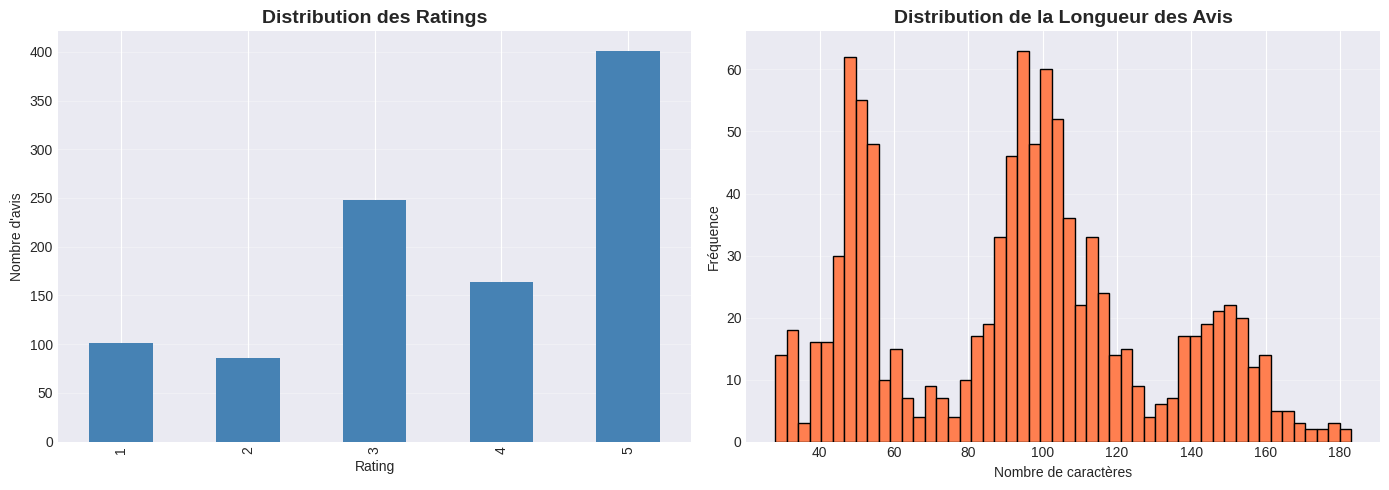

In [ ]:
# Visualisation de la distribution des ratings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des ratings
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution des Ratings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Nombre d\'avis')
axes[0].grid(axis='y', alpha=0.3)

# Distribution de la longueur des avis
df['text_length'] = df['text'].str.len()
df['text_length'].hist(bins=50, ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Distribution de la Longueur des Avis', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nombre de caractères')
axes[1].set_ylabel('Fréquence')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/rapport/distribution_ratings.png', dpi=300, bbox_inches='tight')
plt.show()

Distribution des aspects:
ambiance       :  394 (39.4%)
service        :  379 (37.9%)
cleanliness    :  376 (37.6%)
price          :  368 (36.8%)
food           :  364 (36.4%)


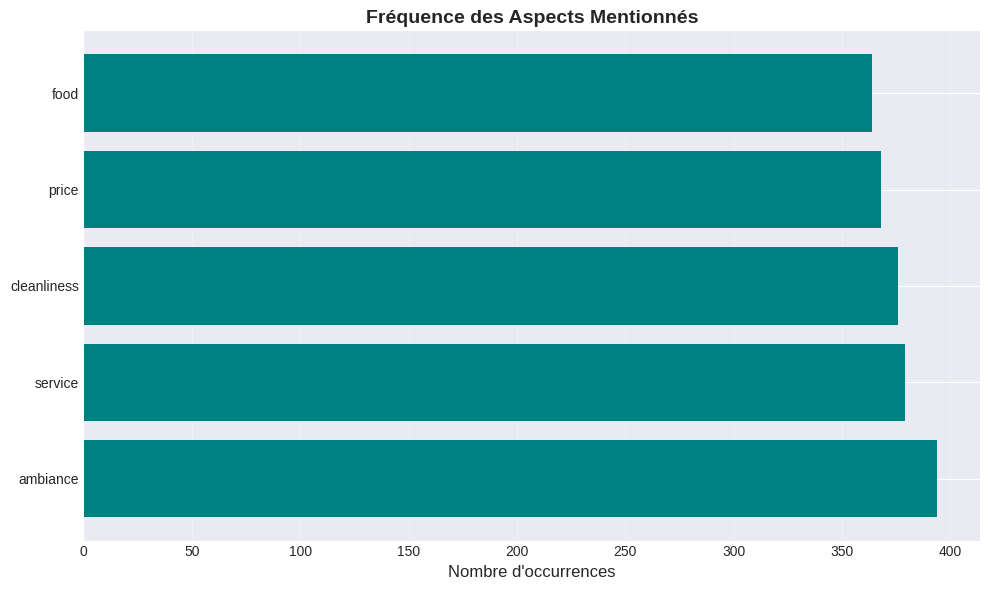

In [ ]:
# Analyse des aspects
from collections import Counter

all_aspects = []
for aspects_str in df['aspects']:
    all_aspects.extend(aspects_str.split(','))

aspect_counts = Counter(all_aspects)
print("Distribution des aspects:")
for aspect, count in aspect_counts.most_common():
    print(f"{aspect:15s}: {count:4d} ({count/len(df)*100:.1f}%)")

# Visualisation
plt.figure(figsize=(10, 6))
aspects_df = pd.DataFrame(aspect_counts.most_common(), columns=['Aspect', 'Count'])
plt.barh(aspects_df['Aspect'], aspects_df['Count'], color='teal')
plt.xlabel('Nombre d\'occurrences', fontsize=12)
plt.title('Fréquence des Aspects Mentionnés', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/rapport/aspect_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Preprocessing des Données

In [ ]:
def preprocess_text(text):
    """Nettoie et prétraite le texte"""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s\.\!\?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['text_clean'] = df['text'].apply(preprocess_text)

print("✅ Preprocessing terminé")
print(f"\nExemple:")
print(f"Original: {df['text'].iloc[0]}")
print(f"Clean:    {df['text_clean'].iloc[0]}")

✅ Preprocessing terminé

Exemple:
Original: Amazing cuisine, the steak was cooked to perfection. The service was impeccable, quick and professional.
Clean:    amazing cuisine the steak was cooked to perfection. the service was impeccable quick and professional.


## 4. Split Train/Test

In [ ]:
X = df['text_clean']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Split terminé")
print(f"Training set: {len(X_train)} avis")
print(f"Test set:     {len(X_test)} avis")
print(f"\nDistribution train:")
print(y_train.value_counts().sort_index())

✅ Split terminé
Training set: 800 avis
Test set:     200 avis

Distribution train:
rating
1     81
2     69
3    198
4    131
5    321
Name: count, dtype: int64


## 5. Feature Extraction - TF-IDF (ENTRAÎNEMENT RÉEL)

In [ ]:
print("🔥 ENTRAÎNEMENT DU VECTORIZER TF-IDF...")

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ TF-IDF entraîné!")
print(f"Matrice shape: {X_train_tfidf.shape}")
print(f"Vocabulaire size: {len(tfidf.vocabulary_)}")
print(f"\nTop 20 features: {tfidf.get_feature_names_out()[:20]}")

🔥 ENTRAÎNEMENT DU VECTORIZER TF-IDF...
✅ TF-IDF entraîné!
Matrice shape: (800, 750)
Vocabulaire size: 750

Top 20 features: ['45' '45 minutes' 'about' 'about the' 'absolutely' 'absolutely delicious'
 'acceptable' 'acceptable but' 'acceptable standard' 'accommodating'
 'accommodating and' 'affordable' 'affordable and' 'affordable prices'
 'all' 'all found' 'all the' 'all very' 'amazing' 'amazing cuisine']


## 6. ENTRAÎNEMENT MODÈLE 1: Logistic Regression

In [ ]:
print("🔥 ENTRAÎNEMENT DU MODÈLE LOGISTIC REGRESSION...\n")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    verbose=1  # Afficher la progression
)

# ENTRAÎNEMENT RÉEL
lr_model.fit(X_train_tfidf, y_train)

print("\n✅ MODÈLE ENTRAÎNÉ AVEC SUCCÈS!")

🔥 ENTRAÎNEMENT DU MODÈLE LOGISTIC REGRESSION...


✅ MODÈLE ENTRAÎNÉ AVEC SUCCÈS!


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


## 7. Évaluation du Modèle

In [ ]:
# Prédictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Métriques
accuracy = accuracy_score(y_test, y_pred_lr)
f1_weighted = f1_score(y_test, y_pred_lr, average='weighted')
f1_macro = f1_score(y_test, y_pred_lr, average='macro')

print("="*60)
print("LOGISTIC REGRESSION - RÉSULTATS RÉELS")
print("="*60)
print(f"Accuracy:        {accuracy:.4f}")
print(f"F1-Score (weighted): {f1_weighted:.4f}")
print(f"F1-Score (macro):    {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['1★', '2★', '3★', '4★', '5★']))

LOGISTIC REGRESSION - RÉSULTATS RÉELS
Accuracy:        0.5850
F1-Score (weighted): 0.5092
F1-Score (macro):    0.3818

Classification Report:
              precision    recall  f1-score   support

          1★       0.40      0.20      0.27        20
          2★       1.00      0.12      0.21        17
          3★       0.56      0.74      0.64        50
          4★       0.20      0.03      0.05        33
          5★       0.62      0.91      0.74        80

    accuracy                           0.58       200
   macro avg       0.56      0.40      0.38       200
weighted avg       0.55      0.58      0.51       200



## 8️⃣ Matrice de Confusion

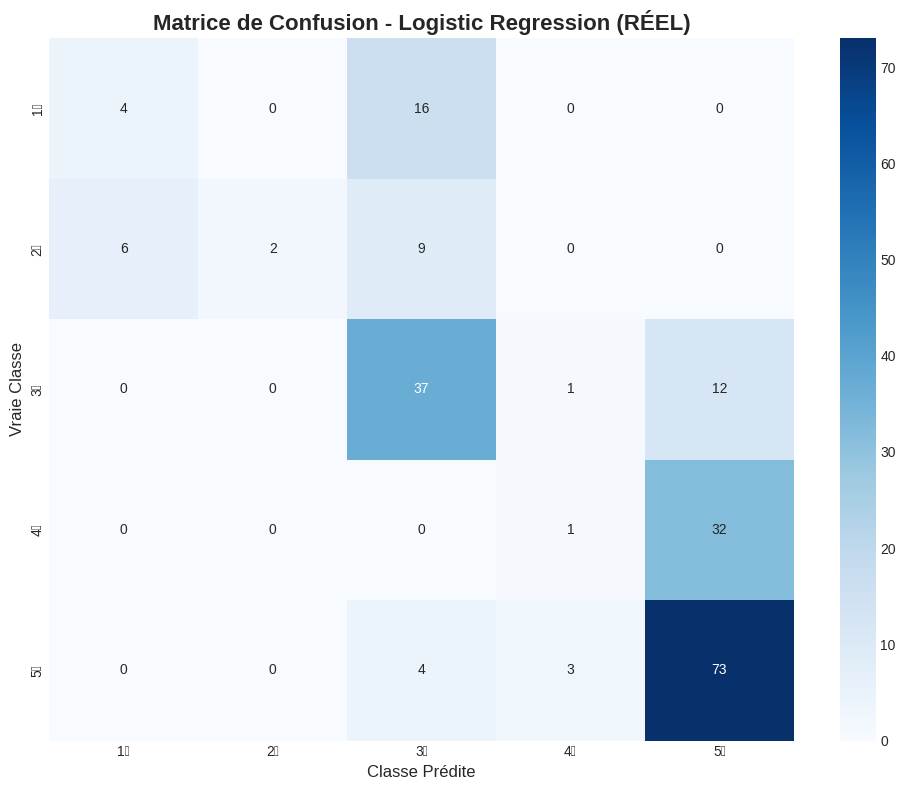

✅ Visualisation créée


In [ ]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1★', '2★', '3★', '4★', '5★'],
            yticklabels=['1★', '2★', '3★', '4★', '5★'])
plt.title('Matrice de Confusion - Logistic Regression (RÉEL)', fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe', fontsize=12)
plt.xlabel('Classe Prédite', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/rapport/confusion_matrix_nb.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisation créée")

## 9️⃣ SAUVEGARDE DES MODÈLES (IMPORTANT!)

In [ ]:
print("💾 SAUVEGARDE DES MODÈLES...\n")

# Sauvegarder le modèle
with open('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✅ Modèle sauvegardé: logistic_regression_model.pkl")

# Sauvegarder le vectorizer
with open('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✅ Vectorizer sauvegardé: tfidf_vectorizer.pkl")

print("\n🎉 TOUS LES FICHIERS SONT SAUVEGARDÉS!")

💾 SAUVEGARDE DES MODÈLES...

✅ Modèle sauvegardé: logistic_regression_model.pkl
✅ Vectorizer sauvegardé: tfidf_vectorizer.pkl

🎉 TOUS LES FICHIERS SONT SAUVEGARDÉS!


## 1️⃣1️⃣ Test du Modèle avec Nouveaux Avis

In [ ]:
def predict_rating(text, model, vectorizer):
    """Prédit le rating pour un nouvel avis"""
    text_clean = preprocess_text(text)
    text_tfidf = vectorizer.transform([text_clean])
    rating = model.predict(text_tfidf)[0]
    proba = model.predict_proba(text_tfidf)[0]
    return rating, proba

# Test avec des exemples
test_reviews = [
    "The food was absolutely amazing! Best pasta ever. Great service too!",
    "Terrible experience. Cold food, rude staff. Never coming back.",
    "It was okay. Nothing special but not bad either."
]

print("🧪 TEST DU MODÈLE AVEC NOUVEAUX AVIS:\n")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    rating, proba = predict_rating(review, lr_model, tfidf)
    print(f"\nAvis {i}: {review}")
    print(f"Prédiction: {rating}★ (confiance: {proba[rating-1]:.2%})")
    print(f"Probabilités: 1★={proba[0]:.2%}, 2★={proba[1]:.2%}, 3★={proba[2]:.2%}, 4★={proba[3]:.2%}, 5★={proba[4]:.2%}")
    print("-"*80)

print("\n✅ Tests terminés avec succès!")

🧪 TEST DU MODÈLE AVEC NOUVEAUX AVIS:


Avis 1: The food was absolutely amazing! Best pasta ever. Great service too!
Prédiction: 5★ (confiance: 45.78%)
Probabilités: 1★=6.77%, 2★=5.87%, 3★=20.92%, 4★=20.66%, 5★=45.78%
--------------------------------------------------------------------------------

Avis 2: Terrible experience. Cold food, rude staff. Never coming back.
Prédiction: 3★ (confiance: 31.10%)
Probabilités: 1★=24.59%, 2★=29.56%, 3★=31.10%, 4★=7.39%, 5★=7.36%
--------------------------------------------------------------------------------

Avis 3: It was okay. Nothing special but not bad either.
Prédiction: 3★ (confiance: 34.32%)
Probabilités: 1★=15.74%, 2★=13.52%, 3★=34.32%, 4★=12.69%, 5★=23.73%
--------------------------------------------------------------------------------

✅ Tests terminés avec succès!


## 📊 Résumé Final

In [ ]:
print("="*80)
print("📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*80)
print(f"\n✅ Dataset: {len(df)} avis")
print(f"✅ Training set: {len(X_train)} avis")
print(f"✅ Test set: {len(X_test)} avis")
print(f"\n✅ Modèle: Logistic Regression")
print(f"✅ Features: TF-IDF ({X_train_tfidf.shape[1]} features)")
print(f"\n✅ Performance:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1-Weighted: {f1_weighted:.4f}")
print(f"   - F1-Macro: {f1_macro:.4f}")
print(f"\n✅ Fichiers sauvegardés:")
print(f"   - logistic_regression_model.pkl")
print(f"   - tfidf_vectorizer.pkl")
print(f"   - restaurant_reviews.csv")
print(f"\n🎉 ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
print("="*80)

📊 RÉSUMÉ DE L'ENTRAÎNEMENT

✅ Dataset: 1000 avis
✅ Training set: 800 avis
✅ Test set: 200 avis

✅ Modèle: Logistic Regression
✅ Features: TF-IDF (750 features)

✅ Performance:
   - Accuracy: 0.5850
   - F1-Weighted: 0.5092
   - F1-Macro: 0.3818

✅ Fichiers sauvegardés:
   - logistic_regression_model.pkl
   - tfidf_vectorizer.pkl
   - restaurant_reviews.csv

🎉 ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!
